<a href="https://colab.research.google.com/github/shreyasym12004/Audiocrypt/blob/main/satelite_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 pip install numpy scipy matplotlib tensorflow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Parameters
fs = 1e6
nsamples = 1024

def generate_signal_data(n_samples=1024, mode='qpsk', snr_db=20, jammed=False):
    num_bits = n_samples if mode == 'bpsk' else n_samples * 2
    bits = np.random.randint(0, 2, num_bits)

    # Modulation
    if mode == 'bpsk':
        iq = (bits * 2 - 1) + 0j
    else: # QPSK
        iq = ((bits[0::2]*2-1) + 1j*(bits[1::2]*2-1)) / np.sqrt(2)

    # Add AWGN
    snr_linear = 10**(snr_db/10)
    noise_volts = np.sqrt(1 / (2 * snr_linear))
    sig = iq + noise_volts * (np.random.randn(n_samples) + 1j*np.random.randn(n_samples))

    # Add Jamming
    if jammed:
        t = np.arange(n_samples)
        sig += 0.5 * np.exp(1j * 2 * np.pi * 0.15 * t) # 150kHz tone

    return np.stack((sig.real, sig.imag), axis=1), bits

# Build the dataset
X, Y = [], []
for _ in range(1000):
    X.append(generate_signal_data(mode='bpsk', snr_db=25)[0]); Y.append(0)
    X.append(generate_signal_data(mode='qpsk', snr_db=25)[0]); Y.append(1)
    X.append(generate_signal_data(snr_db=2)[0]); Y.append(2) # High Noise
    X.append(generate_signal_data(jammed=True)[0]); Y.append(3) # Jammed

X, Y = np.array(X), np.array(Y)
print(f"Dataset ready. X shape: {X.shape}, Y shape: {Y.shape}")

Dataset ready. X shape: (4000, 1024, 2), Y shape: (4000,)


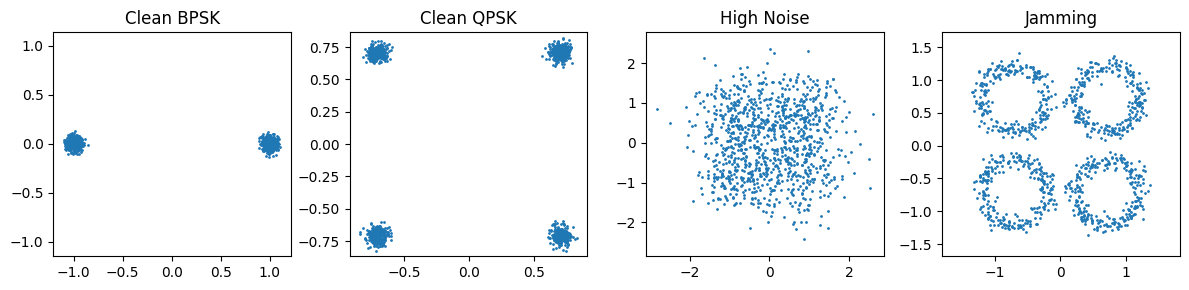

In [3]:
labels = ['Clean BPSK', 'Clean QPSK', 'High Noise', 'Jamming']
plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    idx = np.where(Y == i)[0][0]
    plt.scatter(X[idx,:,0], X[idx,:,1], s=1)
    plt.title(labels[i])
    plt.axis('equal')
plt.tight_layout()
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv1D(64, 7, activation='relu', input_shape=(nsamples, 2)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, Y, epochs=10, validation_split=0.2, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.7855 - loss: 0.6355 - val_accuracy: 1.0000 - val_loss: 0.5892
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.7613 - val_loss: 0.4292
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9925 - val_loss: 0.1461
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0222
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 1.0000 - loss: 8.6536e-04 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 1.0000 - loss: 4.4743e-04 - val_accuracy: 1.0000 - val_loss: 5.4447e-04
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 1.0000 - loss: 2.8746e-04 - val_accuracy: 1.0000 - val_loss: 3.4260e-04
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accura

In [5]:
from scipy.signal import iirnotch, lfilter

def calculate_ber(orig_bits, received_iq, mode='qpsk'):
    if mode == 'bpsk':
        detected = (received_iq[:, 0] > 0).astype(int)
    else:
        b1, b2 = (received_iq[:, 0] > 0).astype(int), (received_iq[:, 1] > 0).astype(int)
        detected = np.empty(b1.size + b2.size, dtype=int)
        detected[0::2], detected[1::2] = b1, b2
    return np.sum(orig_bits != detected) / len(orig_bits)

# Simulate a Jammed QPSK signal
test_iq, true_bits = generate_signal_data(mode='qpsk', jammed=True)
pred = np.argmax(model.predict(test_iq[np.newaxis, ...]), axis=1)[0]

print(f"AI Detected: {labels[pred]}")

# Mitigation Logic
processed_iq = test_iq.copy()
if pred == 3: # Jamming
    b, a = iirnotch(0.15, 30) # Notch at 150kHz
    processed_iq[:,0] = lfilter(b, a, test_iq[:,0])
    processed_iq[:,1] = lfilter(b, a, test_iq[:,1])

ber_final = calculate_ber(true_bits, processed_iq, mode='qpsk')
print(f"Final BER after Mitigation: {ber_final:.5f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
AI Detected: Jamming
Final BER after Mitigation: 0.00244


125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step


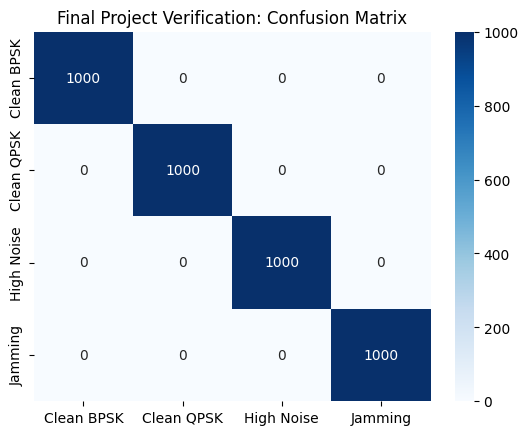

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X), axis=1)
cm = confusion_matrix(Y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Final Project Verification: Confusion Matrix')
plt.show()